# Fix position 

## Preprocessing offline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

from astropy import units as u
from odisseo.units import CodeUnits
from odisseo.option_classes import SimulationParams, PlummerParams, MNParams, NFWParams, PSPParams

from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)



params_true = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


def selection_function(x, p_selecteion=0.95):
        # Implement a selection function based on the problem requirements
        x_selected = x[np.random.rand(x.shape[0]) < p_selecteion]  # Example: select 50% of the data
        return x_selected

def add_background(x, p_backgrouond=1e-3 ):
        N = 1e6
        N_background = np.random.binomial(n=N, p=p_backgrouond)
        x_background = np.random.uniform(low=np.array([6, -120, -8, -250, -2., -0.10]),
                                          high=np.array([20, 70, 2, 250, 1.0, 0.10]),
                                          size=(N_background, 6))
        x_and_background = np.concatenate((x, x_background), axis=0)
        return x_and_background

def add_noise(x, noise_std = np.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
        x_noise = np.random.normal(loc=x, scale=noise_std, size=x.shape)
        return x_noise

def transform_in_histogram(x, bins=[64, 32]):
        ph1_phi2, _, _ = np.histogram2d(x[:, 1], x[:, 2], bins = bins, range = [[-120., 70.], [-8, 2]] )
        R_vR, _, _ = np.histogram2d(x[:, 0], x[:, 3], bins = bins, range = [[6., 20.], [-250., 250.]] )
        vphicosphi2_vphi2, _, _ = np.histogram2d(x[:, 4], x[:, 5], bins = bins, range = [[-2., 1.], [-0.1, 0.1 ]] )
        return np.stack([ph1_phi2, R_vR, vphicosphi2_vphi2], axis=0)

def to_observation(x, p_selection=0.95, p_background=1e-3):
        """
        Convert simulation data to observation format by applying selection, adding background, noise, and transforming to histogram.
        """
        x_selected = selection_function(x, p_selection)
        x_with_background = add_background(x_selected, p_background)
        x_noise = add_noise(x_with_background)
        x_histogram = transform_in_histogram(x_noise) 
        return x_histogram

def to_inference_parameters(theta, code_units=code_units, ):
        """
        convert from simulation parameters to inference parameters
        """
        theta[0] = theta[0] # t_end is already in Gyr
        theta[1] = np.log10(theta[1]).item() # Plummer mass is already in Msun
        theta[2] = theta[2] * code_units.code_length.to(u.kpc) # Plummer a
        theta[3] = np.log10(theta[3] * code_units.code_mass.to(u.Msun)).item()  # NFW Mvir
        theta[4] = theta[4] * code_units.code_length.to(u.kpc)  # NFW r_s
        theta[5] = np.log10(theta[5] * code_units.code_mass.to(u.Msun)).item() # MN M
        theta[6] = theta[6] * code_units.code_length.to(u.kpc) # MN a
        return theta


def from_simulation_to_observation_and_inference(file, save_path, p_selection=0.95, p_background=1e-3, code_units=code_units):
    """
    Convert simulation data to observation format and inference parameters.
    """
    x, theta = np.load(file)['x'], np.load(file)['theta']
    x_observation = to_observation(x, p_selection=p_selection, p_background=p_background)
    theta_inference = to_inference_parameters(theta, code_units=code_units)
    np.savez(save_path, x=x_observation, theta=theta_inference)



#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/'
files_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz') ]
save_directory = '/export/data/vgiusepp/odisseo_data/data_fix_position/preprocess'

for file in tqdm(files_path):
       file_name_to_save = 'preprocess_'+os.path.basename(file)
       save_path = os.path.join(save_directory, file_name_to_save )
#        print(f"Processed {file} and saved to {save_path}")
#        from_simulation_to_observation_and_inference(
#               file=file,
#               save_path=save_path,
#               p_selection=0.95,
#               p_background=1e-3,)
        



/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(
100%|██████████| 37176/37176 [00:00<00:00, 766650.17it/s]


In [ ]:
# On the fly prepocessing with pytorch
# import torch

# def selection_function(x, p_selection=0.95):
#     mask = torch.rand(x.shape[0], device=x.device) < p_selection
#     return x[mask]

# def add_background(x, p_background=1e-3):
#     N = int(1e6)
#     N_background = torch.distributions.Binomial(total_count=N, probs=p_background).sample().int()

#     low = torch.tensor([6., -120., -8., -250., -2., -0.10], device=x.device)
#     high = torch.tensor([20., 70., 2., 250., 1.0, 0.10], device=x.device)

#     # Uniform sampling in the given box
#     x_background = (high - low) * torch.rand((N_background, 6), device=x.device) + low

#     x_background = torch.distributions.Uniform(low=low, high=high).sample((N_background, )).to(x.device)
#     print(x.shape, x_background.shape)

#     return torch.cat([x, x_background], dim=0)

# def add_noise(x, noise_std=torch.tensor([0.25, 0.001, 0.15, 5., 0.1, 1e-3])):
#     noise_std = noise_std.to(x.device)
#     x_noise = torch.distributions.Normal(x, noise_std).sample((x.shape[0],))
#     return x_noise

# def transform_in_histogram(x, bins=[64, 32]):
    

#     # ph1_ph2 = hist2d(x[:, 1], x[:, 2], bins, [-120., 70.], [-8., 2.])
#     # R_vR = hist2d(x[:, 0], x[:, 3], bins, [6., 20.], [-250., 250.])
#     # vphicosphi2_vphi2 = hist2d(x[:, 4], x[:, 5], bins, [-2., 1.], [-0.1, 0.1])

#     phi1_phi2, _, _ = torch.histogramdd(torch.stack([x[:, 1], x[:, 2]], axis=1), bins=bins, range=[-120., 70., -8., 2.])
#     R_vR, _, _ = torch.histogramdd(torch.stack([x[:, 0], x[:, 3]], axis=1), bins=bins, range=[6., 20., -250., 250.])
#     vphicosphi2_vphi2, _, _ = torch.histogramdd(torch.stack([x[:, 4], x[:, 5]], axis=1), bins=bins, range=[-2., 1., -0.1, 0.1])
#     return torch.stack([phi1_phi2, R_vR, vphicosphi2_vphi2], dim=0)

# def to_observation(x, p_selection=0.95, p_background=1e-3):
#     x_selected = selection_function(x, p_selection)
#     x_with_background = add_background(x_selected, p_background)
#     x_noise = add_noise(x_with_background)
#     x_histogram = transform_in_histogram(x_noise)
#     return x_histogram


# file = '/export/data/vgiusepp/odisseo_data/data_varying_position/file_000000.npz'
# x, theta = np.load(file)['x'], np.load(file)['theta']
# x = torch.tensor(x, )
# theta = torch.tensor(theta, )
# x_observation = to_observation(x, p_selection=0.95, p_background=1e-3)
# print(theta)

## Training , validation and test set generation

In [2]:
from autocvd import autocvd
autocvd(num_gpus = 1)

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from astropy import units as u



class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npz", transform=None, code_units=code_units):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        # self.file_paths = self._filter_valid_paths(file_paths)
        self.file_paths = file_paths
        self.file_type = file_type
        self.transform = transform

        path = self.file_paths[0]
        if self.file_type == "npz":
            x = np.load(path)['x'], #for some unknown reason this reaturns a tuple with an array inside 
            theta = np.load(path)['theta'] 
            x, theta = torch.from_numpy(x[0]).float(), torch.from_numpy(theta).float()
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x = data['x']  #for some unknown reason this reaturns a tuple with an array inside 
                theta = data['theta']
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        path = self.file_paths[idx]
        x, theta = np.load(path)['x'], np.load(path)['theta']
        x, theta = torch.from_numpy(x).float(), torch.from_numpy(theta).float()
        self.tensors = x, theta

        return x, theta
    
    

#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/preprocess'
data_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz')]
files_path_obs = data_path[-1]
data_path = data_path[:-1]  # Exclude the last file which is the observation
#split the data into training, validation, and test sets
files_path_training = data_path[ : int(len(data_path) * 0.8)]
files_path_validation = data_path[int(len(data_path) * 0.8) : int(len(data_path) * 0.9)]
files_path_test = data_path[int(len(data_path) * 0.9) : ]


#Training
dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=1024, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print('Training set shapes for x and theta:')
    # print(batch[0].shape, batch[1].shape)
    print(batch[0].shape)
    break

#Validation
dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=1024, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print('Validation set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

#Test
dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print('Test set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

# Observation
# files_path_obs = sorted(
#     f for f in Path(data_path).glob("chunk_*.npz")
#     if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 70_000)
x_obs = torch.from_numpy(np.load(files_path_obs)['x'])
theta_obs = torch.from_numpy(np.load(files_path_obs)['theta'])
print(theta_obs)



2025-06-10 19:35:46.241478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749576946.261087   62790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749576946.266071   62790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
torch.Size([1, 3, 64, 32]) torch.Size([1, 7])
Training set shapes for x and theta:
torch.Size([1024, 3, 64, 32])
torch.Size([1, 3, 64, 32]) torch.Size([1, 7])
Validation set shapes for x and theta:
torch.Size([1024, 3, 64, 32]) torch.Size([1024, 7])
torch.Size([1, 3, 64, 32]) torch.Size([1, 7])
Test set shapes for x and theta:
torch.Size([512, 3, 64, 32]) torch.Size([512, 7])
tensor([4.5030e+00, 4.1828e+00, 1.5476e-02, 1.1714e+01, 2.1763e+01, 1.1114e+01,
        1.4994e+00], dtype=torch.float64)


## Embedding network

In [3]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down = Down(64, 128)
        self.up = Up(128, 64, False)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.down(x0)
        up = self.up(x1, x0)
        f = self.outc(up)
        return f


class LinearCompression(nn.Module):
    def __init__(self, out_channels=32):
        super(LinearCompression, self).__init__()
        self.sequential = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(out_channels),
        )

    def forward(self, x):
        return self.sequential(x)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

class embedding_network(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(embedding_network, self).__init__()
        self.unet = Unet(in_channels, out_channels)
        self.linear_compression = LinearCompression(out_channels=out_channels)
        self.flatten = nn.Flatten(1)
    
    def forward(self, x):
        x = self.unet(x)
        x = self.flatten(x)
        x = self.linear_compression(x)
        return x


embedding_net = embedding_network()


## Inference pipeline

In [4]:
# ltu-ili 
loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, # t_end in Gyr
                                np.log10(10**3.0).item(), # Plummer mass
                                params_true.Plummer_params.a*(1/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(1/4) * code_units.code_mass.to(u.Msun)).item(),
                                params_true.NFW_params.r_s*(1/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(1/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.MN_params.a*(1/4) * code_units.code_length.to(u.kpc), ], 
                            high=[5, # t_end in Gyr
                                np.log10(10**4.5).item(), #Plummer mass
                                params_true.Plummer_params.a*(8/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.NFW_params.r_s*(8/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.MN_params.a*(8/4) * code_units.code_length.to(u.kpc),], 
                            device=device),

  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,),
         ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,)],
  device = device,
  train_args = {'stop_after_epochs': 20, 'max_epochs': 200}
)

posterior, summary = trainer(loader)                  # Run training to map data -> parameters

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
53 epochs [11:16, 12.76s/ epochs, loss=-0.186, loss_val=0.719]  
INFO:root:Training model 2 / 2.
43 epochs [09:11, 12.83s/ epochs, loss=-0.0956, loss_val=1.16] 
INFO:root:It took 1238.8028087615967 seconds to train models.


INFO:root:Sampling models with [5686, 4314] samples each.
Drawing 5686 posterior samples:   0%|          | 0/5686 [00:00<?, ?it/s]

Drawing 5686 posterior samples: 5968it [00:00, 44048.48it/s]                          
Drawing 4314 posterior samples: 4535it [00:00, 38048.43it/s]            


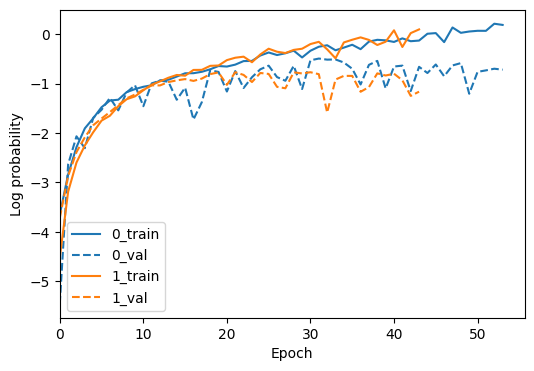

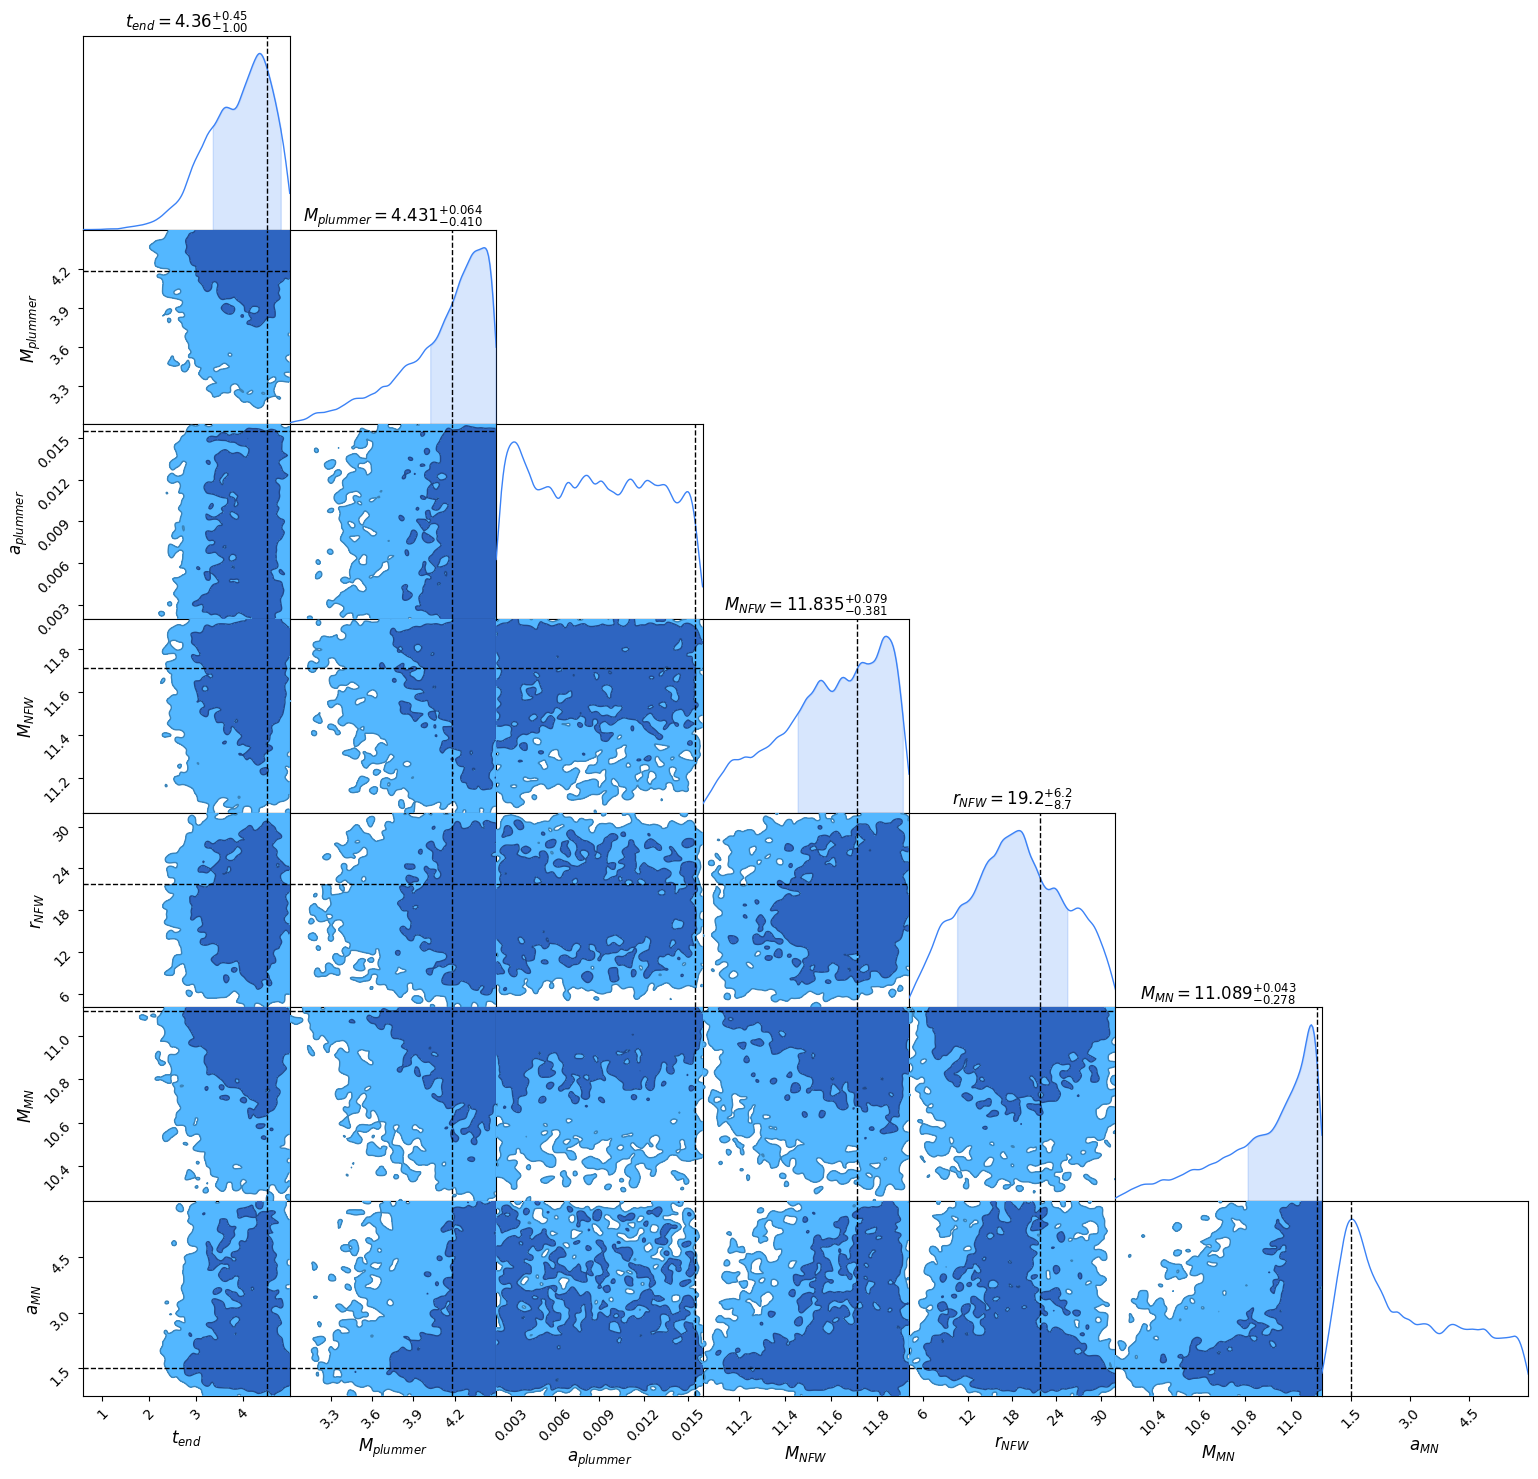

In [ ]:
# REMBEMBDER SBI <= 0.22

samples = posterior.sample(                     # Generate 1000 samples from the posterior for input x[0]
  x=x_obs.unsqueeze(0), shape=(10_000,)
)

# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summary):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

fig.savefig("./fix_position_inference/log_probabilities.pdf", bbox_inches='tight', format='pdf')

df_sample = pd.DataFrame(samples.cpu(), columns=['$t_{end}$', 
                                           '$M_{plummer}$',
                                             '$a_{plummer}$', 
                                             '$M_{NFW}$', 
                                             '$r_{NFW}$',
                                               '$M_{MN}$', 
                                               '$a_{MN}$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_sample, name='samples NPE'))
c.add_truth(Truth(location={'$t_{end}$': theta_obs[0] ,
                           '$M_{plummer}$': theta_obs[1] ,
                           '$a_{plummer}$': theta_obs[2] ,
                           '$M_{NFW}$': theta_obs[3] ,
                           '$r_{NFW}$': theta_obs[4] ,
                           '$M_{MN}$': theta_obs[5] ,
                           '$a_{MN}$': theta_obs[6] ,}))
fig = c.plotter.plot()

fig.savefig("./fix_position_inference/posterior_plot.pdf", bbox_inches='tight', format='pdf')



def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

               
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['$t_{end}$', '$M_{plummer}$', '$a_{plummer}$', '$M_{NFW}$', '$r_{NFW}$', '$M_{MN}$', '$a_{MN}$'],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None)


fig = metric(
    posterior=posterior,
    x=x.unsqueeze(1), theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./fix_position_inference/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')
               


# Varying position

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

from astropy import units as u
from odisseo.units import CodeUnits
from odisseo.option_classes import SimulationParams, PlummerParams, MNParams, NFWParams, PSPParams

from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)



params_true = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


def selection_function(x, p_selecteion=0.95):
        # Implement a selection function based on the problem requirements
        x_selected = x[np.random.rand(x.shape[0]) < p_selecteion]  # Example: select 50% of the data
        return x_selected

def add_background(x, p_backgrouond=1e-3 ):
        N = 1e6
        N_background = np.random.binomial(n=N, p=p_backgrouond)
        x_background = np.random.uniform(low=np.array([6, -120, -8, -250, -2., -0.10]),
                                          high=np.array([20, 70, 2, 250, 1.0, 0.10]),
                                          size=(N_background, 6))
        x_and_background = np.concatenate((x, x_background), axis=0)
        return x_and_background

def add_noise(x, noise_std = np.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
        x_noise = np.random.normal(loc=x, scale=noise_std, size=x.shape)
        return x_noise

def transform_in_histogram(x, bins=[64, 32]):
        ph1_phi2, _, _ = np.histogram2d(x[:, 1], x[:, 2], bins = bins, range = [[-120., 70.], [-8, 2]] )
        R_vR, _, _ = np.histogram2d(x[:, 0], x[:, 3], bins = bins, range = [[6., 20.], [-250., 250.]] )
        vphicosphi2_vphi2, _, _ = np.histogram2d(x[:, 4], x[:, 5], bins = bins, range = [[-2., 1.], [-0.1, 0.1 ]] )
        return np.stack([ph1_phi2, R_vR, vphicosphi2_vphi2], axis=0)

def to_observation(x, p_selection=0.95, p_background=1e-3):
        """
        Convert simulation data to observation format by applying selection, adding background, noise, and transforming to histogram.
        """
        x_selected = selection_function(x, p_selection)
        x_with_background = add_background(x_selected, p_background)
        x_noise = add_noise(x_with_background)
        x_histogram = transform_in_histogram(x_noise) 
        return x_histogram

def to_inference_parameters(theta, code_units=code_units, ):
        """
        convert from simulation parameters to inference parameters. The position do not need to be converted to kpc since they are already in kpc and km/s
        """
        theta[0] = theta[0] # t_end is already in Gyr
        theta[1] = np.log10(theta[1]).item() # Plummer mass is already in Msun
        theta[2] = theta[2] * code_units.code_length.to(u.kpc) # Plummer a
        theta[3] = np.log10(theta[3] * code_units.code_mass.to(u.Msun)).item()  # NFW Mvir
        theta[4] = theta[4] * code_units.code_length.to(u.kpc)  # NFW r_s
        theta[5] = np.log10(theta[5] * code_units.code_mass.to(u.Msun)).item() # MN M
        theta[6] = theta[6] * code_units.code_length.to(u.kpc) # MN a
        return theta


def from_simulation_to_observation_and_inference(file, save_path, p_selection=0.95, p_background=1e-3, code_units=code_units):
    """
    Convert simulation data to observation format and inference parameters.
    """
    x, theta = np.load(file)['x'], np.load(file)['theta']
    x_observation = to_observation(x, p_selection=p_selection, p_background=p_background)
    theta_inference = to_inference_parameters(theta, code_units=code_units)
    np.savez(save_path, x=x_observation, theta=theta_inference)



#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_varying_position/'
files_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz')]
save_directory = '/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess'

for file in tqdm(files_path):
       file_name_to_save = 'preprocess_'+os.path.basename(file)
       save_path = os.path.join(save_directory, file_name_to_save )
#        print(f"Processed {file} and saved to {save_path}")
       from_simulation_to_observation_and_inference(
              file=file,
              save_path=save_path,
              p_selection=0.95,
              p_background=1e-3,)
        

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(
100%|██████████| 6720/6720 [01:26<00:00, 77.42it/s] 


## Training, validation and test set generation

In [2]:
from autocvd import autocvd
autocvd(num_gpus = 1)

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from astropy import units as u



class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npz", transform=None, code_units=code_units):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        # self.file_paths = self._filter_valid_paths(file_paths)
        self.file_paths = file_paths
        self.file_type = file_type
        self.transform = transform

        path = self.file_paths[0]
        if self.file_type == "npz":
            x = np.load(path)['x'], #for some unknown reason this reaturns a tuple with an array inside 
            theta = np.load(path)['theta'] 
            x, theta = torch.from_numpy(x[0]).float(), torch.from_numpy(theta).float()
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x = data['x']  #for some unknown reason this reaturns a tuple with an array inside 
                theta = data['theta']
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        path = self.file_paths[idx]
        x, theta = np.load(path)['x'], np.load(path)['theta']
        x, theta = torch.from_numpy(x).float(), torch.from_numpy(theta).float()
        self.tensors = x, theta

        return x, theta
    
    

#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess'
data_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz')]
files_path_obs = data_path[-1]
data_path = data_path[:-1]  # Exclude the last file which is the observation
#split the data into training, validation, and test sets
files_path_training = data_path[ : int(len(data_path) * 0.8)]
files_path_validation = data_path[int(len(data_path) * 0.8) : int(len(data_path) * 0.9)]
files_path_test = data_path[int(len(data_path) * 0.9) : ]


#Training
dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=1024, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print('Training set shapes for x and theta:')
    # print(batch[0].shape, batch[1].shape)
    print(batch[0].shape)
    break

#Validation
dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=1024, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print('Validation set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

#Test
dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print('Test set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

# Observation
# files_path_obs = sorted(
#     f for f in Path(data_path).glob("chunk_*.npz")
#     if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 70_000)
x_obs = torch.from_numpy(np.load(files_path_obs)['x'])
theta_obs = torch.from_numpy(np.load(files_path_obs)['theta'])
print(theta_obs)



2025-06-10 20:40:05.544461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749580805.566156  153540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749580805.572549  153540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
torch.Size([1, 3, 64, 32]) torch.Size([1, 13])
Training set shapes for x and theta:
torch.Size([1024, 3, 64, 32])
torch.Size([1, 3, 64, 32]) torch.Size([1, 13])
Validation set shapes for x and theta:
torch.Size([672, 3, 64, 32]) torch.Size([672, 13])
torch.Size([1, 3, 64, 32]) torch.Size([1, 13])
Test set shapes for x and theta:
torch.Size([512, 3, 64, 32]) torch.Size([512, 13])
tensor([ 2.8369e+00,  4.0309e+00,  4.4169e-03,  1.1481e+01,  2.6855e+01,
         1.0988e+01,  5.9226e+00,  1.3629e+01,  3.2518e-01,  6.8770e+00,
         1.1078e+02, -2.5185e+02, -9.4548e+01], dtype=torch.float64)


## Embedding

In [3]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down = Down(64, 128)
        self.up = Up(128, 64, False)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.down(x0)
        up = self.up(x1, x0)
        f = self.outc(up)
        return f


class LinearCompression(nn.Module):
    def __init__(self, out_channels=32):
        super(LinearCompression, self).__init__()
        self.sequential = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(out_channels),
        )

    def forward(self, x):
        return self.sequential(x)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

class embedding_network(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(embedding_network, self).__init__()
        self.unet = Unet(in_channels, out_channels)
        self.linear_compression = LinearCompression(out_channels=out_channels)
        self.flatten = nn.Flatten(1)
    
    def forward(self, x):
        x = self.unet(x)
        x = self.flatten(x)
        x = self.linear_compression(x)
        return x


embedding_net = embedding_network()


## Inference pipeline

In [ ]:
# ltu-ili 
loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, # t_end in Gyr
                                np.log10(10**3.0).item(), # Plummer mass
                                params_true.Plummer_params.a*(1/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(1/4) * code_units.code_mass.to(u.Msun)).item(),
                                params_true.NFW_params.r_s*(1/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(1/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.MN_params.a*(1/4) * code_units.code_length.to(u.kpc), ], 
                            high=[5, # t_end in Gyr
                                np.log10(10**4.5).item(), #Plummer mass
                                params_true.Plummer_params.a*(8/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.NFW_params.r_s*(8/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                params_true.MN_params.a*(8/4) * code_units.code_length.to(u.kpc),], 
                            device=device),

  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,),
         ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,)],
  device = device,
  train_args = {'stop_after_epochs': 20, 'max_epochs': 200}
)

posterior, summary = trainer(loader)                  # Run training to map data -> parameters

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
62 epochs [03:58,  3.82s/ epochs, loss=15.4, loss_val=16.7]

In [ ]:
# REMBEMBDER SBI <= 0.22

samples = posterior.sample(                     # Generate 1000 samples from the posterior for input x[0]
  x=x_obs.unsqueeze(0), shape=(10_000,)
)

# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summary):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

fig.savefig("./varying_position_inference/log_probabilities.pdf", bbox_inches='tight', format='pdf')

df_sample = pd.DataFrame(samples.cpu(), columns=['$t_{end}$', 
                                           '$M_{plummer}$',
                                             '$a_{plummer}$', 
                                             '$M_{NFW}$', 
                                             '$r_{NFW}$',
                                               '$M_{MN}$', 
                                               '$a_{MN}$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_sample, name='samples NPE'))
c.add_truth(Truth(location={'$t_{end}$': theta_obs[0] ,
                           '$M_{plummer}$': theta_obs[1] ,
                           '$a_{plummer}$': theta_obs[2] ,
                           '$M_{NFW}$': theta_obs[3] ,
                           '$r_{NFW}$': theta_obs[4] ,
                           '$M_{MN}$': theta_obs[5] ,
                           '$a_{MN}$': theta_obs[6] ,}))
fig = c.plotter.plot()

fig.savefig("./varying_position_inference/posterior_plot.pdf", bbox_inches='tight', format='pdf')



def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

               
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['$t_{end}$', '$M_{plummer}$', '$a_{plummer}$', '$M_{NFW}$', '$r_{NFW}$', '$M_{MN}$', '$a_{MN}$'],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None)


fig = metric(
    posterior=posterior,
    x=x.unsqueeze(1), theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./varying_position_inference/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')
               
